**One-shot learning** is an object categorization method where unlike traditional machine learning and deep learning methods where they use hundreds or thousands of samples/images and very large datasets, one-shot learning uses 'one or few samples/ images to categorize the images.
Hence the name one-shot learning.

In this project i have applied 'Siamese neural network' and other simpler models on 'Omniglot dataset' to see how they perform.. 

In [0]:
import os
import imageio
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import time

In [0]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


OMNIGLOT DATA SET
Description: The Omniglot dataset contains over 1600 handwritten characters from 50 different alphabets. It's used for studying one-shot learning and for developing more human-like learning algorithms.

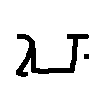

In [0]:
Image.open("images_background/Alphabet_of_the_Magi/character01/0709_01.png")

In [0]:
# convert image to numpy array
def load_image(infilename ) :
  img = Image.open( infilename )
  img.load()
  data = np.asarray( img, dtype="int32" )
  return data

In [0]:
img = load_image("images_background/Alphabet_of_the_Magi/character01/0709_01.png")
img.shape

(105, 105)

In [0]:
def get_pairs(list):
  return zip(range(len(list)), list)

In [0]:
def get_alphabets(path):
  alphabet_names = os.listdir(path)
  alphabet_names.sort()
  alphabet_dict = {}
  alphabet_dict['names'] = alphabet_names
  alphabet_dict['sizes'] = []

  for alphabet_name in alphabet_names: 
    alphabet_path = os.path.join(path, alphabet_name)
    alphabet = {}
    alphabet_dict[alphabet_name] = alphabet
    alphabet['name'] = alphabet_name
    char_names = os.listdir(alphabet_path)
    char_names.sort()
    alphabet_size = len(char_names)
    alphabet['size'] = alphabet_size
    alphabet_dict['sizes'].append(alphabet_size)

    for char_idx, char_name in get_pairs(char_names):
      char_path = os.path.join(alphabet_path, char_name)
      example_names = os.listdir(char_path)
      example_names.sort()

      for example_idx, example_name in get_pairs(example_names):
        image_path = os.path.join(char_path, example_name)
        image = imageio.imread(image_path)
        alphabet[(char_idx, example_idx)] = 255 - image
        
  return alphabet_dict

In [0]:
train_path = 'images_background'
train_data = get_alphabets(train_path)

val_path = 'images_evaluation'
val_data = get_alphabets(val_path)

In [0]:
'''list of all the names of languages in the training(images_background) data'''
train_data['names']

['Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh']

In [0]:
'''list of all the names of languages in the validation(images_evaluation) data'''
val_data['names']

['Angelic',
 'Atemayar_Qelisayer',
 'Atlantean',
 'Aurek-Besh',
 'Avesta',
 'Ge_ez',
 'Glagolitic',
 'Gurmukhi',
 'Kannada',
 'Keble',
 'Malayalam',
 'Manipuri',
 'Mongolian',
 'Old_Church_Slavonic_(Cyrillic)',
 'Oriya',
 'Sylheti',
 'Syriac_(Serto)',
 'Tengwar',
 'Tibetan',
 'ULOG']

In [0]:
# displaying all the alphabets of a language
def display_alphabet(alphabet, example_idx=0):
  table_size = math.ceil(math.sqrt(alphabet['size']))
  plt.figure(figsize=(10, 10))
  for char_idx in range(alphabet['size']):
    plt.subplot(table_size, table_size, char_idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(alphabet[(char_idx, example_idx)], cmap='gray_r')
  plt.show()

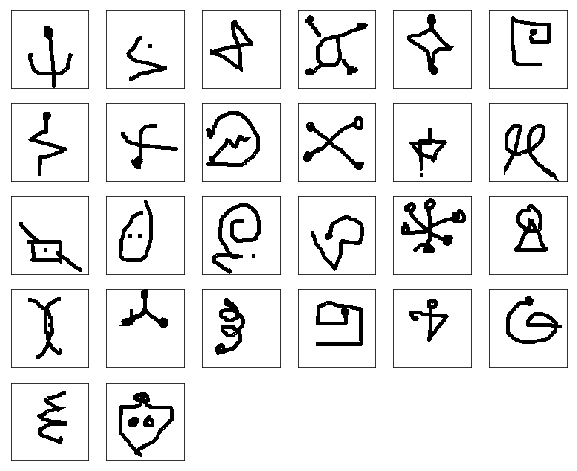

In [0]:
# alphabets of Futurama - first image from each character of each alphabet of the language
display_alphabet(train_data['Futurama'])

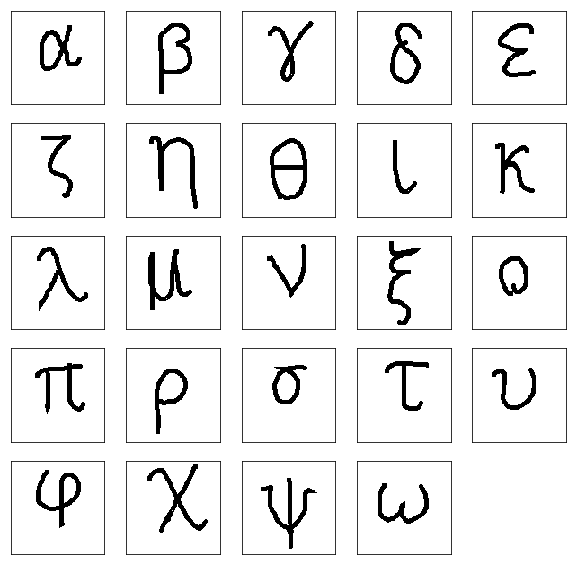

In [0]:
# alphabets of Greek - first image from each character of each alphabet of the language
display_alphabet(train_data['Greek'])

In [0]:
def get_batch(data, batch_size):
  total_size = sum(data['sizes'])
  prob = [size / total_size for size in data['sizes']]
  
  left_input = np.zeros((batch_size, 105, 105, 1))
  right_input = np.zeros((batch_size, 105, 105, 1))
  output = np.zeros((batch_size,))
  
  for idx in np.arange(batch_size):
    # select random alphabet with prob 
    #   (its number of characters / total number of characters)
    left_alphabet_name = np.random.choice(data['names'], p=prob)
    # select random character
    left_character_idx = np.random.randint(low = 0, high = data[left_alphabet_name]['size'])

    if np.random.uniform() < 0.5: 
      similarity = 1.0
      right_alphabet_name = left_alphabet_name
      right_character_idx = left_character_idx
    else:
      similarity = 0.0
      while True:
        # select random alphabet
        right_alphabet_name = np.random.choice(data['names'], p=prob)
        # select random character
        right_character_idx = np.random.randint(low = 0, high = data[right_alphabet_name]['size'])
        if left_alphabet_name != right_alphabet_name or left_character_idx != right_character_idx:
          break

    # select random example
    left_example_idx = np.random.randint(low = 0, high = 20) 
    # select random example
    right_example_idx = np.random.randint(low = 0, high = 20)
    
    left_input[idx, :, :, :] = data[left_alphabet_name][(left_character_idx, left_example_idx)].reshape((105, 105, 1))
    right_input[idx, :, :, :] = data[right_alphabet_name][(right_character_idx, right_example_idx)].reshape((105, 105, 1))
    output[idx] = similarity
    
  return [left_input, right_input], output

In [0]:
def pair_generator(data, batch_size):
  while True:
    yield get_batch(data, batch_size)

In [0]:
import random
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input, Lambda, Conv2D
from keras.datasets import mnist
from keras.optimizers import Adam
import matplotlib.pyplot as plt

i want to build 3 different models and compare their model accuracies and select the best model with the highest accuracy to do one shot classification.

----------------------------------------------------------------------------------------------------------------

for the 1st model instead of passing a pair of images through a CNN and extracting their feature vector and comparing  them .
i simple wanted to see how a model performs when if we just flatten the entire image.
im pretty sure that model does not do well , lets see





In [0]:
'''
we build a simple model where we flatten the images(105 X 105) and calculate the similarity 
between the vectors.
'''

def simple_model(input_shape):
  input = Input((105,105, 1))
  x = Flatten()(input)
  #x = Dense(128, activation = 'relu')(x)
  dense = Model(input, x)
  
  input1 = Input(input_shape)
  input2 = Input(input_shape)
  
  dense1 = dense(input1)
  dense2 = dense(input2)
  
  
  L1_dist = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  merge_layer = L1_dist([dense1, dense2])
  dense_layer = Dense(1, activation = 'sigmoid')(merge_layer)
  basic_model = Model(inputs = [input1, input2], outputs = dense_layer)
  
  return basic_model

In [0]:
model = simple_model((105,105,1)) 
model.summary()

W0801 09:27:35.897281 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 09:27:35.938697 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 09:27:35.983815 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 11025)        0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 11025)        0           model_1[1][0]                    
          

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


W0801 09:27:36.020700 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0801 09:27:36.053388 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0801 09:27:36.062343 139843508201344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history_1 = model.fit_generator(pair_generator(train_data, 32), steps_per_epoch=200, epochs=100)

W0801 09:27:36.302705 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/100
200/200 [==============================] - 6s 29ms/step - loss: 7.6202 - acc: 0.5239
Epoch 2/100
200/200 [==============================] - 2s 11ms/step - loss: 7.7366 - acc: 0.5158
Epoch 3/100
200/200 [==============================] - 2s 11ms/step - loss: 7.3339 - acc: 0.5431
Epoch 4/100
200/200 [==============================] - 2s 11ms/step - loss: 7.4462 - acc: 0.5358
Epoch 5/100
200/200 [==============================] - 2s 11ms/step - loss: 7.3066 - acc: 0.5455
Epoch 6/100
200/200 [==============================] - 2s 11ms/step - loss: 7.7399 - acc: 0.5155
Epoch 7/100
200/200 [==============================] - 2s 11ms/step - loss: 8.0442 - acc: 0.4956
Epoch 8/100
200/200 [==============================] - 2s 11ms/step - loss: 8.0836 - acc: 0.4934
Epoch 9/100
200/200 [==============================] - 2s 11ms/step - loss: 8.0241 - acc: 0.4972
Epoch 10/100
200/200 [==============================] - 2s 11ms/step - loss: 7.9771 - acc: 0.5002
Epoch 11/100
200/200 [=======

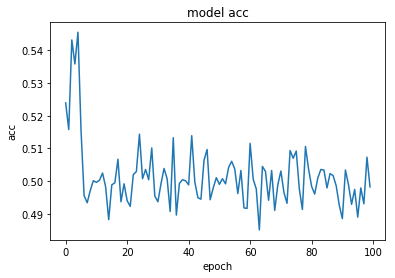

In [0]:
plt.plot(history_1.history['acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()


as predicted the model did not do well , the reason is simple when we pass an image through a CNN model in the last layer before flatten the CNN extracts key features that defines the image for example if we pass an image of a cat through a trained CNN in the last layer the model extracts key features of cat the defines it like "whiskers" or "pointy ears" which helps the model to identity the image.
but in the above model we simply flattened the entire image that defeats the whole purpose..

For the 2nd model I build a simple 2 layered CNN nothing specific, i went through keras functional API  and found a sample code for shared vision problem (https://keras.io/getting-started/functional-api-guide/) and used that model architecture to see how it performs when we add CONVOLUTION.

ofc i will be using the same method as before but instead of flatten the entire image , here the image passes through a couple of CNN layers and the extracted feature vectors and flatten and their abs difference is fully connected to a dense layer of unit one and activation sigmoid..

In [0]:
 
def cnn_model(input_shape):
    
    # tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # conv
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    
    
    # encodings (feature vectors) for the two images
    left_encoding = model(left_input)
    right_encoding = model(right_input)
    
    # customized layer to compute the absolute difference between the feature vectors
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([left_encoding, right_encoding])
    
    # dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # siamese model connecting the two inputs
    siamese_model = Model(inputs=[left_input, right_input], outputs=prediction)
    
    return siamese_model

In [0]:
model = cnn_model((105, 105, 1)) 
model.summary()

W0801 09:31:16.666515 139843508201344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 160000)       37568       input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 160000)       0           sequential_1[1][0]               
          

In [0]:
optimizer = Adam(lr=0.00005)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])
history_2 = model.fit_generator(pair_generator(train_data, 32), steps_per_epoch=200, epochs=100)

Epoch 1/100
200/200 [==============================] - 26s 132ms/step - loss: 2.5821 - acc: 0.5555
Epoch 2/100
200/200 [==============================] - 23s 116ms/step - loss: 1.4589 - acc: 0.6016
Epoch 3/100
200/200 [==============================] - 23s 116ms/step - loss: 1.0337 - acc: 0.6369
Epoch 4/100
200/200 [==============================] - 23s 116ms/step - loss: 0.9210 - acc: 0.6280
Epoch 5/100
200/200 [==============================] - 23s 116ms/step - loss: 0.8028 - acc: 0.6514
Epoch 6/100
200/200 [==============================] - 23s 116ms/step - loss: 0.7353 - acc: 0.6644
Epoch 7/100
200/200 [==============================] - 23s 116ms/step - loss: 0.7283 - acc: 0.6659
Epoch 8/100
200/200 [==============================] - 23s 116ms/step - loss: 0.6902 - acc: 0.6697
Epoch 9/100
200/200 [==============================] - 23s 115ms/step - loss: 0.6451 - acc: 0.6878
Epoch 10/100
200/200 [==============================] - 23s 116ms/step - loss: 0.6381 - acc: 0.6903
Epoch 11/

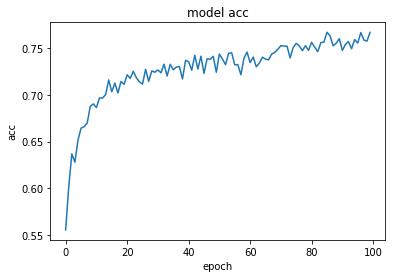

In [0]:
plt.plot(history_2.history['acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

as we can see the model did pretty good its a jump from 49% to 77% , considered the fact that i havent experimented on the archtecture or hypertuned it in anyway . i just wanted to see how much of difference does it make by simple adding convolutional layer to the model.

------------------------------------------------------------------------------------------------------------------

now as for the 3rd model we will build a neural network model that was build exclusively for omnilot dataset by Gregory Koch et al in their paper [link text](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf?source=post_page---------------------------)![alt text](https://miro.medium.com/max/2400/1*v40QXakPBOmiq4lCKbPu8w.png) 

the arch is a 5 CNN layers with maxpooling and activation relu the number of kernels and size at each layers are as shown in the diagram above..
after the 5th CNN layer we flatten the input image and fully connect it to a dense layer of size 4096 
 here 4096 represent extracted feature vector of an input image.
 
 then as mentioned above we extract feature vector from a pair of images from the same CNN and we calculate absolute diffrernce (L_1 distance) between them and we sent that similarity score through another dense fully connected layer with one unit and activation function 'sigmoid' so that the similarity score ranges between 0 to 1 .. and output 0 means 'not' similar and 1 mean similar.
 
 

In [0]:
 def get_siamese_model(input_shape):
    
    # tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # conv
    model = Sequential()
    model.add(Conv2D(64, (10, 10),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4),activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096,activation='sigmoid'))
    
    # encodings (feature vectors) for the two images
    left_encoding = model(left_input)
    right_encoding = model(right_input)
    
    # customized layer to compute the absolute difference between the feature vectors
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([left_encoding, right_encoding])
    
    # dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # siamese model connecting the two inputs
    siamese_model = Model(inputs=[left_input, right_input], outputs=prediction)
    
    return siamese_model

In [0]:
model = get_siamese_model((105, 105, 1)) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_2[1][0]               
          

In [0]:
optimizer = Adam(lr=0.00005)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])
history_3 = model.fit_generator(pair_generator(train_data, 32), steps_per_epoch=200, epochs=100)

Epoch 1/100
200/200 [==============================] - 37s 186ms/step - loss: 0.6321 - acc: 0.6484
Epoch 2/100
200/200 [==============================] - 35s 174ms/step - loss: 0.5891 - acc: 0.6969
Epoch 3/100
200/200 [==============================] - 35s 175ms/step - loss: 0.5250 - acc: 0.7572
Epoch 4/100
200/200 [==============================] - 35s 175ms/step - loss: 0.4586 - acc: 0.8092
Epoch 5/100
200/200 [==============================] - 35s 174ms/step - loss: 0.4126 - acc: 0.8319
Epoch 6/100
200/200 [==============================] - 35s 175ms/step - loss: 0.3639 - acc: 0.8663
Epoch 7/100
200/200 [==============================] - 35s 175ms/step - loss: 0.3311 - acc: 0.8789
Epoch 8/100
200/200 [==============================] - 35s 175ms/step - loss: 0.3090 - acc: 0.8880
Epoch 9/100
200/200 [==============================] - 35s 174ms/step - loss: 0.3003 - acc: 0.8950
Epoch 10/100
200/200 [==============================] - 35s 175ms/step - loss: 0.2790 - acc: 0.9036
Epoch 11/

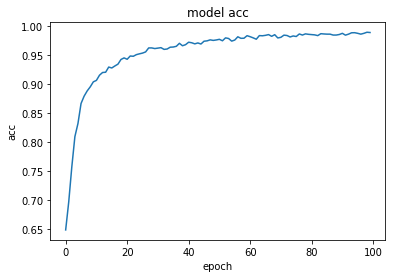

In [0]:
plt.plot(history_3.history['acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()

from 49% to 78% to 98% (almost or close enough SOTA )its the most significant jump made CNN models. 
clearly this model is the best .Gregory Koch et al experimented and fine tuned to this CNN model to extract best feature vectors that defines the image. 

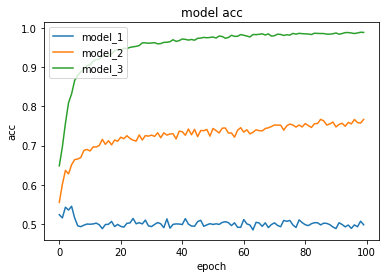

In [0]:
plt.plot(history_1.history['acc'], label = 'model_1')
plt.plot(history_2.history['acc'], label = 'model_2')
plt.plot(history_3.history['acc'], label = 'model_3')
plt.legend(['model_1','model_2' ,'model_3'], loc='upper left')
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.show()


In [0]:
def get_one_shot(data, num):
  total_size = sum(data['sizes'])
  prob = [size / total_size for size in data['sizes']]
  
  left_input = np.zeros((num, 105, 105, 1))
  right_input = np.zeros((num, 105, 105, 1))
  
  right_choices = []
  
  # select random alphabet with prob 
  #   (its number of characters / total number of characters)
  left_alphabet_name = np.random.choice(data['names'], p=prob)
  # select random character
  left_character_idx = np.random.randint(low = 0, high = data[left_alphabet_name]['size'])
  # select random example
  left_example_idx = np.random.randint(low = 0, high = 20) 
  
  left_choice = (left_alphabet_name, left_character_idx, left_example_idx)
  
  for idx in np.arange(num):
    if idx == 0:
      right_alphabet_name = left_alphabet_name
      right_character_idx = left_character_idx
    else:
      while True:
        # select random alphabet
        right_alphabet_name = np.random.choice(data['names'], p=prob)
        # select random character
        right_character_idx = np.random.randint(low = 0, high = data[right_alphabet_name]['size'])
        if left_alphabet_name != right_alphabet_name or left_character_idx != right_character_idx:
          break

    # select random example
    right_example_idx = np.random.randint(low = 0, high = 20)
    
    left_input[idx, :, :, :] = data[left_alphabet_name][(left_character_idx, left_example_idx)].reshape((105, 105, 1))
    right_input[idx, :, :, :] = data[right_alphabet_name][(right_character_idx, right_example_idx)].reshape((105, 105, 1))
  
    right_choices.append((right_alphabet_name, right_character_idx, right_example_idx))
  
  
  return [left_input, right_input], left_choice, right_choices

In [0]:
def display_one_shot(model, data, num):
  pairs, left_choice, right_choices = get_one_shot(val_data, num)
  similarity_scores = model.predict(pairs)
  best_idx = np.argmax(similarity_scores)
  num = len(right_choices)
  size = math.ceil(math.sqrt(num))
  plt.figure(figsize=(10, 10))
  # left choice
  plt.subplot(size + 1, size + 1, 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  alphabet_name, character_idx, example_idx = left_choice
  plt.imshow(data[alphabet_name][(character_idx, example_idx)], cmap='gray_r')
  
  # right choices
  for row in range(size):
    for col in range(size):
      idx = row * size + col
      if idx < num:
        alphabet_name, character_idx, example_idx = right_choices[idx]
        plt.subplot(size + 1, size + 1, (size + 1) * row + col + 2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        if idx == best_idx:
          if best_idx == 0:
            color = 'green'
          else:
            color = 'red'
        else:
          color = 'black'
        plt.title('{0:.4f}'.format(similarity_scores[row * size + col, 0]), color=color)
        plt.imshow(data[alphabet_name][(character_idx, example_idx)], cmap='gray_r')
  plt.show()

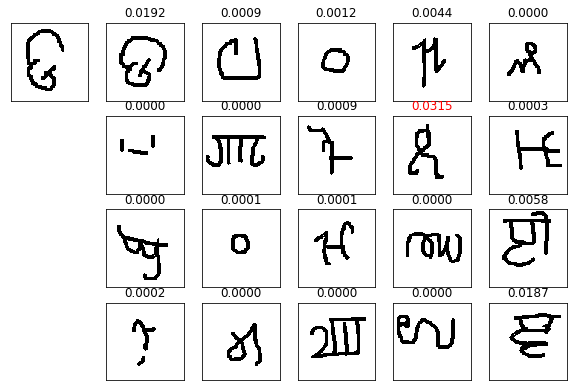

In [0]:
# using model_3 to predict 20 way one shot learning.
display_one_shot(model, val_data, 20)

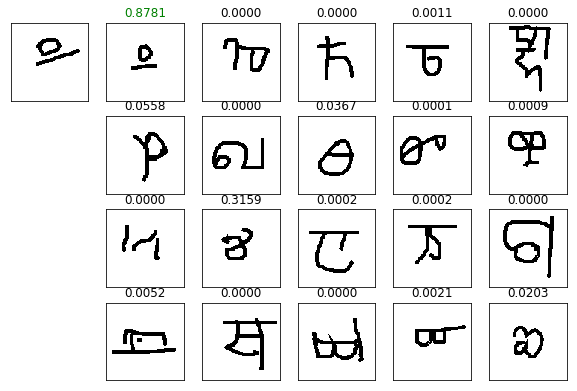

In [0]:
display_one_shot(model, val_data, 20)

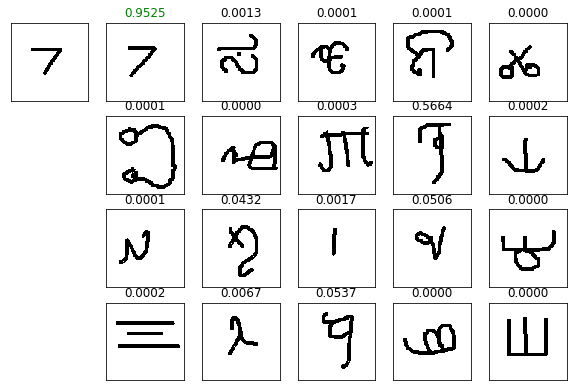

In [0]:
display_one_shot(model, val_data, 20)

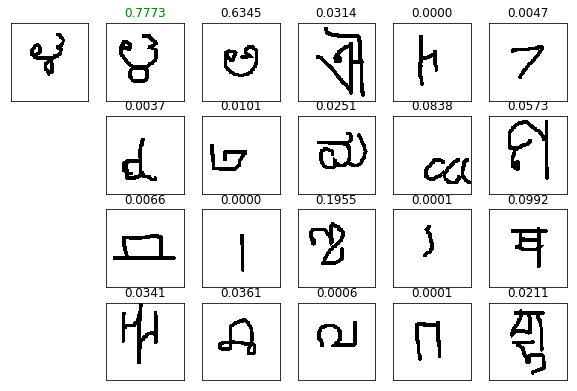

In [0]:
display_one_shot(model, val_data, 20)

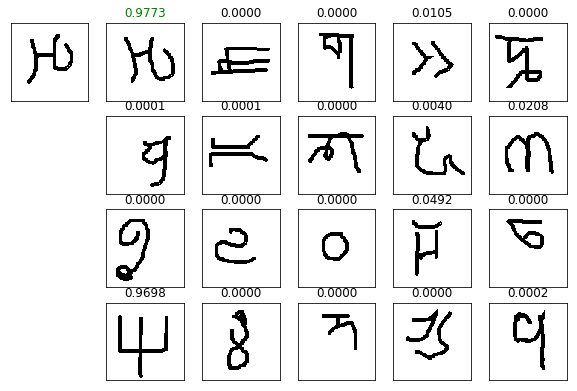

In [0]:
display_one_shot(model, val_data, 20)